In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
import pandas as pd
import numpy as np

# === Set image directories ===
train_img_dir = Path("/workspaces/InternshipSkincare/data/ISIC-2017_Training_Data")
val_img_dir   = Path("/workspaces/InternshipSkincare/data/ISIC-2017_Validation_Data")
test_img_dir  = Path("/workspaces/InternshipSkincare/data/ISIC-2017_Test_v2_Data")
# === File paths ===
train_gt_path = "/workspaces/InternshipSkincare/data/ISIC-2017_Training_Part3_GroundTruth.csv"
val_gt_path   = "/workspaces/InternshipSkincare/data/ISIC-2017_Validation_Part3_GroundTruth.csv"
test_gt_path  = "/workspaces/InternshipSkincare/data/ISIC-2017_Test_v2_Part3_GroundTruth.csv"

# === Load and clean ===
def load_and_clean(path):
    df = pd.read_csv(path)
    df.columns = ["image_id", "melanoma", "seborrheic_keratosis"]
    return df[["image_id", "melanoma"]]

train_gt = load_and_clean(train_gt_path)
val_gt   = load_and_clean(val_gt_path)
test_gt  = load_and_clean(test_gt_path)

# # === Balanced train sample ===
mel_train = train_gt[train_gt["melanoma"] == 1]
nonmel_train = train_gt[train_gt["melanoma"] == 0]

mel_sampled = mel_train.sample(n=250, random_state=42)
nonmel_sampled = nonmel_train.sample(n=250, random_state=42)

train_gt_500 = pd.concat([mel_sampled, nonmel_sampled], ignore_index=True).sample(frac=1, random_state=42)

# === Sample proportional to full dataset distribution ===
# mel_train = train_gt[train_gt["melanoma"] == 1]
# nonmel_train = train_gt[train_gt["melanoma"] == 0]

# mel_sampled = mel_train.sample(n=93, random_state=42)
# nonmel_sampled = nonmel_train.sample(n=407, random_state=42)

# train_gt_500 = pd.concat([mel_sampled, nonmel_sampled], ignore_index=True).sample(frac=1, random_state=42)
# === Sanity check ===
print("Balanced Train set (500):")
print(train_gt_500["melanoma"].value_counts())
print("Val set:", val_gt["melanoma"].value_counts().to_dict())
print("Test set:", test_gt["melanoma"].value_counts().to_dict())



Balanced Train set (500):
melanoma
0.0    250
1.0    250
Name: count, dtype: int64
Val set: {0.0: 120, 1.0: 30}
Test set: {0.0: 483, 1.0: 117}


In [126]:
# === ImageNet normalization constants ===
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

# === Image loading function (224x224 + normalization) ===
def load_and_process_image(image_path, target_size=(224, 224)):
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            raise RuntimeError(f"Failed to read image: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        image = image.astype(np.float32) / 255.0
        image = (image - IMAGENET_MEAN) / IMAGENET_STD
        image = image.transpose(2, 0, 1)  # CxHxW
        image_id = image_path.stem
        return image_id, image
    except Exception as e:
        raise RuntimeError(f"Error processing image {image_path}: {e}")

# === Parallel loader ===
def load_image_data_parallel(image_dir, df, target_size=(224, 224), max_workers=8):
    data = {}
    labels = {}
    futures = {}

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for _, row in df.iterrows():
            image_id = row["image_id"]
            label = int(row["melanoma"])
            path = image_dir / f"{image_id}.jpg"
            if path.exists():
                futures[executor.submit(load_and_process_image, path, target_size)] = (image_id, label)

        for future in as_completed(futures):
            image_id, label = futures[future]
            loaded_id, image = future.result()
            if loaded_id and image is not None:
                data[loaded_id] = image
                labels[loaded_id] = label

    return data, labels


In [127]:
train_images, train_labels = load_image_data_parallel(train_img_dir, train_gt_500)

In [128]:
len(train_images)

500

In [129]:
val_images, val_labels = load_image_data_parallel(val_img_dir, val_gt)

In [130]:
test_images, test_labels = load_image_data_parallel(test_img_dir, test_gt)

In [131]:
class Config:
    OUTPUT_DIR = 'working'
    BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, "best_model.pt")

config = Config()

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchvision.models import ResNet18_Weights

class ImageDictDataset(Dataset):
    def __init__(self, data_dict, label_dict):
        self.keys = list(data_dict.keys())
        self.data_dict = data_dict
        self.label_dict = label_dict

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        x = torch.tensor(self.data_dict[key], dtype=torch.float32)
        y = torch.tensor([self.label_dict[key]], dtype=torch.float32)
        return x, y

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

def evaluate_metrics(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.view(-1).to(device)
            logits = model(x).view(-1)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)

    # AUC
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = 0.0

    # Sensitivity and Specificity
    cm = confusion_matrix(all_labels, all_preds)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    else:
        sensitivity = specificity = 0.0

    return auc, acc, sensitivity, specificity


def build_resnet18_binary():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 1)  # Binary output
    return model


In [133]:
def train_binary_model(train_dict, val_dict, train_labels, val_labels, epochs=10, lr=1e-4, batch_size=32, save_name="resnet18_binary"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_ds = ImageDictDataset(train_dict, train_labels)
    val_ds = ImageDictDataset(val_dict, val_labels)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size)

    model = build_resnet18_binary().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
    loss_fn = nn.BCEWithLogitsLoss()

    history = {
        "epoch": [],
        "train_loss": [],
        "train_auc": [],
        "train_acc": [],
        "train_sens": [],
        "train_spec": [],
        "val_auc": [],
        "val_acc": [],
        "val_sens": [],
        "val_spec": [],
        "current_lr": []
    }

    best_auc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            y = y.view(-1)
            logits = model(x).view(-1)
            loss = loss_fn(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_auc, train_acc, train_sens, train_spec = evaluate_metrics(model, train_dl, device)
        val_auc, val_acc, val_sens, val_spec = evaluate_metrics(model, val_dl, device)
        scheduler.step(val_auc)
        current_lr = scheduler.optimizer.param_groups[0]['lr']

        # Save history
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(total_loss)
        history["train_auc"].append(train_auc)
        history["train_acc"].append(train_acc)
        history["train_sens"].append(train_sens)
        history["train_spec"].append(train_spec)
        history["val_auc"].append(val_auc)
        history["val_acc"].append(val_acc)
        history["val_sens"].append(val_sens)
        history["val_spec"].append(val_spec)
        history["current_lr"].append(current_lr)

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), os.path.join(config.OUTPUT_DIR, f"{save_name}_best.pt"))

        print(f"Epoch {epoch+1} — Loss: {total_loss:.2f} "
              f"— Train AUC: {train_auc:.4f} — Val AUC: {val_auc:.4f} "
              f"— Train Acc: {train_acc:.4f} — Val Acc: {val_acc:.4f} "
              f"— Sens: {val_sens:.3f} — Spec: {val_spec:.3f} "
              f"— LR: {current_lr:.2e} {'<-- best' if val_auc == best_auc else ''}")

    pd.DataFrame(history).to_csv(os.path.join(config.OUTPUT_DIR, f"training_history_{save_name}.csv"), index=False)
    print(f"✅ Done. Best Val AUC: {best_auc:.4f}")
    return model


Image: ISIC_0000157 — Size: 224x224


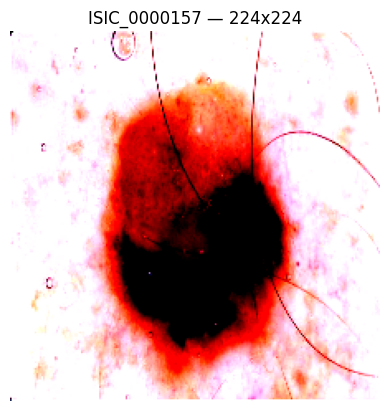

In [134]:
def plot_sample_image(data_dict):
    sample_key = list(data_dict.keys())[0]
    img_tensor = data_dict[sample_key]  # shape C x H x W
    img_np = img_tensor.transpose(1, 2, 0)  # H x W x C
    h, w = img_np.shape[:2]
    print(f"Image: {sample_key} — Size: {h}x{w}")
    plt.imshow(np.clip(img_np, 0, 1))
    plt.title(f"{sample_key} — {h}x{w}")
    plt.axis('off')
    plt.show()
plot_sample_image(train_images)

In [136]:
model = train_binary_model(
    train_dict=train_images,
    val_dict=val_images,
    train_labels=train_labels,
    val_labels=val_labels,
    epochs=7,         # or any number you want
    lr=1e-4,           # learning rate
    batch_size=32,     # batch size
    save_name="resnet18_binary_bal"
)

Epoch 1 — Loss: 10.68 — Train AUC: 0.8160 — Val AUC: 0.6917 — Train Acc: 0.8160 — Val Acc: 0.5867 — Sens: 0.867 — Spec: 0.517 — LR: 1.00e-04 <-- best
Epoch 2 — Loss: 3.75 — Train AUC: 0.9960 — Val AUC: 0.7458 — Train Acc: 0.9960 — Val Acc: 0.7733 — Sens: 0.700 — Spec: 0.792 — LR: 1.00e-04 <-- best
Epoch 3 — Loss: 1.27 — Train AUC: 1.0000 — Val AUC: 0.7250 — Train Acc: 1.0000 — Val Acc: 0.8000 — Sens: 0.600 — Spec: 0.850 — LR: 1.00e-04 
Epoch 4 — Loss: 0.68 — Train AUC: 1.0000 — Val AUC: 0.7292 — Train Acc: 1.0000 — Val Acc: 0.7467 — Sens: 0.700 — Spec: 0.758 — LR: 5.00e-05 
Epoch 5 — Loss: 0.29 — Train AUC: 1.0000 — Val AUC: 0.7375 — Train Acc: 1.0000 — Val Acc: 0.7800 — Sens: 0.667 — Spec: 0.808 — LR: 5.00e-05 
Epoch 6 — Loss: 0.27 — Train AUC: 1.0000 — Val AUC: 0.7500 — Train Acc: 1.0000 — Val Acc: 0.7800 — Sens: 0.700 — Spec: 0.800 — LR: 5.00e-05 <-- best
Epoch 7 — Loss: 0.16 — Train AUC: 1.0000 — Val AUC: 0.7333 — Train Acc: 1.0000 — Val Acc: 0.7733 — Sens: 0.667 — Spec: 0.800 — LR

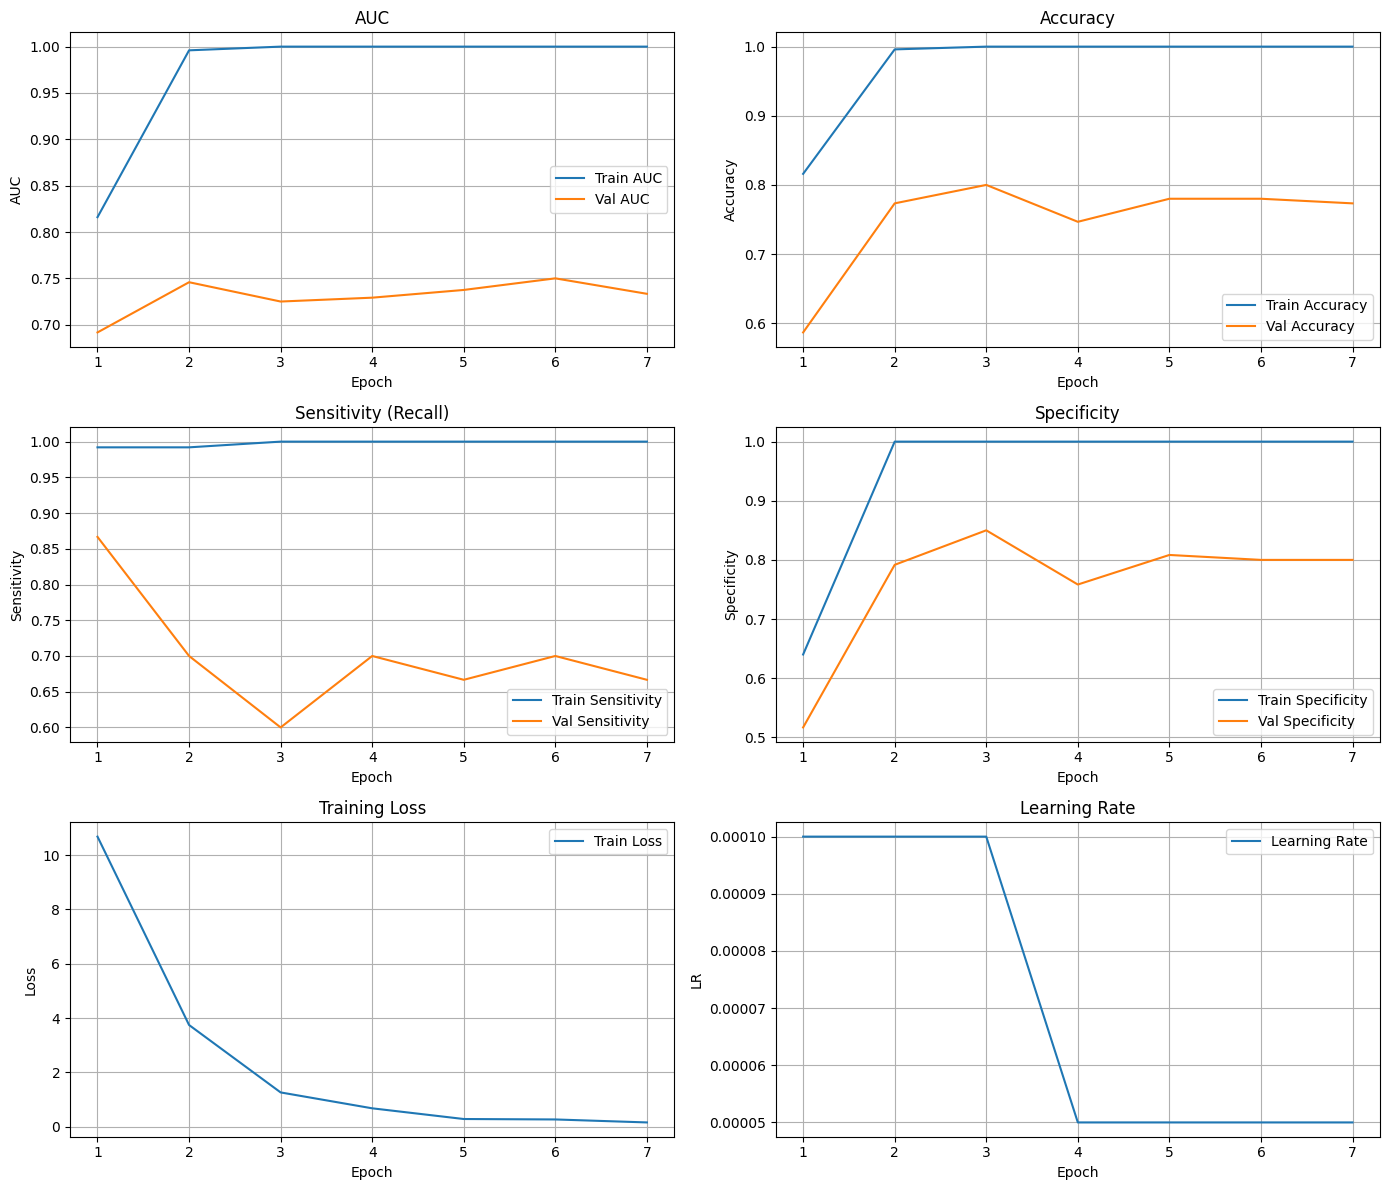

In [138]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved training history
history_path = "/workspaces/InternshipSkincare/working/training_history_resnet18_binary_bal.csv"
history = pd.read_csv(history_path)

# Plotting all key metrics
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# AUC
axs[0, 0].plot(history["epoch"], history["train_auc"], label="Train AUC")
axs[0, 0].plot(history["epoch"], history["val_auc"], label="Val AUC")
axs[0, 0].set_title("AUC")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("AUC")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Accuracy
axs[0, 1].plot(history["epoch"], history["train_acc"], label="Train Accuracy")
axs[0, 1].plot(history["epoch"], history["val_acc"], label="Val Accuracy")
axs[0, 1].set_title("Accuracy")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Sensitivity
axs[1, 0].plot(history["epoch"], history["train_sens"], label="Train Sensitivity")
axs[1, 0].plot(history["epoch"], history["val_sens"], label="Val Sensitivity")
axs[1, 0].set_title("Sensitivity (Recall)")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Sensitivity")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Specificity
axs[1, 1].plot(history["epoch"], history["train_spec"], label="Train Specificity")
axs[1, 1].plot(history["epoch"], history["val_spec"], label="Val Specificity")
axs[1, 1].set_title("Specificity")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Specificity")
axs[1, 1].legend()
axs[1, 1].grid(True)

# Loss
axs[2, 0].plot(history["epoch"], history["train_loss"], label="Train Loss")
axs[2, 0].set_title("Training Loss")
axs[2, 0].set_xlabel("Epoch")
axs[2, 0].set_ylabel("Loss")
axs[2, 0].legend()
axs[2, 0].grid(True)

# Learning Rate
axs[2, 1].plot(history["epoch"], history["current_lr"], label="Learning Rate")
axs[2, 1].set_title("Learning Rate")
axs[2, 1].set_xlabel("Epoch")
axs[2, 1].set_ylabel("LR")
axs[2, 1].legend()
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()


In [139]:
from sklearn.metrics import confusion_matrix

def evaluate_full_metrics(model, dataloader, device):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.view(-1).to(device)
            logits = model(x).view(-1)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    auc = roc_auc_score(all_labels, all_probs)
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    else:
        sensitivity = specificity = 0.0

    return {
        "AUC": auc,
        "Accuracy": acc,
        "Sensitivity (Recall)": sensitivity,
        "Specificity": specificity
    }

In [150]:
import torch

# Assuming you saved the model using `save_name = "resnet18_binary"`
model_path = "/workspaces/InternshipSkincare/working/resnet18_binary_bal_best.pt"

# Rebuild the model and load weights
model = build_resnet18_binary()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Prepare the test DataLoader
test_ds = ImageDictDataset(test_images, test_labels)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

# Evaluate on the test set
test_metrics = evaluate_full_metrics(model, test_dl, device)
test_metrics

{'AUC': np.float64(0.8090637221072003),
 'Accuracy': 0.7216666666666667,
 'Sensitivity (Recall)': np.float64(0.717948717948718),
 'Specificity': np.float64(0.722567287784679)}

bal 
{'AUC': np.float64(0.8090637221072003),
 'Accuracy': 0.7216666666666667,
 'Sensitivity (Recall)': np.float64(0.717948717948718),
 'Specificity': np.float64(0.722567287784679)}

unbal
{'AUC': np.float64(0.7696377696377696),
 'Accuracy': 0.7583333333333333,
 'Sensitivity (Recall)': np.float64(0.5897435897435898),
 'Specificity': np.float64(0.7991718426501035)}

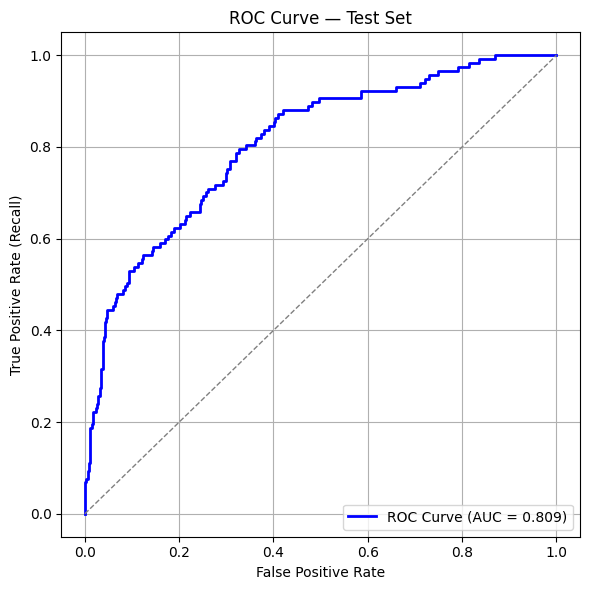

In [147]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Collect predicted probabilities and true labels for ROC
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        y = y.view(-1).to(device)
        logits = model(x).view(-1)
        probs = torch.sigmoid(logits)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve — Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
